In [78]:
#ALL IMPORTS
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import re
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import warnings
import matplotlib.cbook
import matplotlib.ticker as ticker

In [79]:
# Open files and Load DATA
sns.set_theme()
with open("C:\\Users\\maxbr\\Desktop\\Polito\\Thesis SCION\\ETHZ-AP\\latestStats.json") as f:
    data = json.load(f)

with open("C:\\Users\\maxbr\\Desktop\\Polito\\Thesis SCION\\ETHZ-AP\\availableServers.json") as f:
    servers = json.load(f)

with open("C:\\Users\\maxbr\\Desktop\\Polito\\Thesis SCION\\ETHZ-AP\\bw_tests.json") as f:
    bw = json.load(f)

with open("C:\\Users\\maxbr\\Desktop\\Polito\\Thesis SCION\\ETHZ-AP\\loss_tests.json") as f:
    lss = json.load(f)

In [80]:
# # Convert list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data)
servers_df = pd.DataFrame(servers)
dfbw = pd.DataFrame(bw)
dflss = pd.DataFrame(lss)

# # Convert the avg_latency column to numeric and save it back to the dataframe
df['avg_latency'] = pd.to_numeric(df['avg_latency'].str.replace('ms', ''))
#print(type(int(servers_df['_id'][0])))
servers_df['_id'] = pd.to_numeric(servers_df['_id'])

# Convert 'hops_number' column to numeric
df['hops_number'] = pd.to_numeric(df['hops_number']).astype(int)

# Remove the timestamp from the _id column and save it back to the dataframe as "serverId_pathId"
df['_id'] = df['_id'].apply(lambda x: re.sub(r'_(\d{4}-\d{2}-\d{2}).*|-\d{2}:\d{2}:\d{2}\.\d{6}|_$', '', x))

# Remove the timestamp from the _id column and save it back to the dataframe as "serverId_pathId"
dfbw['_id'] = dfbw['_id'].apply(lambda x: re.sub(r'_(\d{4}-\d{2}-\d{2}).*|-\d{2}:\d{2}:\d{2}\.\d{6}|_$', '', x))

# Remove the timestamp from the _id column and save it back to the dataframe as "serverId_pathId"
dflss['_id'] = dflss['_id'].apply(lambda x: re.sub(r'_(\d{4}-\d{2}-\d{2}).*|-\d{2}:\d{2}:\d{2}\.\d{6}|_$', '', x))


In [81]:
# Used to create the legend and color stuff

# List of unique destinations in DataFrame
destinations = df['_id'].str.split('_', expand=True)[0].unique()
df['dest'] = df['_id'].str.split('_', expand=True)[0]

# Create a DataFrame with the minimum and maximum hops for each destination
destination_hops_info = df.groupby('dest')['hops_number'].agg(['min', 'max']).reset_index()

# Compute max over 'max' column and min over 'min' column
max_hops = destination_hops_info['max'].max()
min_hops = destination_hops_info['min'].min()
num_hops = max_hops - min_hops + 1
colormap = cm.get_cmap('Set1', num_hops)

# Create a dictionary to map each destination to its color palette
colormap_dict = {}
for destination in destinations:
    # print("ITERATION #", destination)
    min_hops = destination_hops_info[destination_hops_info['dest'].str.startswith(destination)]['min'].iloc[0]
    max_hops = destination_hops_info[destination_hops_info['dest'].str.startswith(destination)]['max'].iloc[0]
    colormap_dict[destination] = {hops: colormap(i) for i, hops in enumerate(range(min_hops, max_hops + 1))}

# Function to assign colors based on destination and hops_number
def assign_color(row):
    destination = row['_id'].split('_')[0]
    hops = row['hops_number']
    return colormap_dict[destination][hops]

# Apply the function to create the 'color' column
df['color'] = df.apply(assign_color, axis=1)

warnings.filterwarnings("ignore", category=UserWarning)

C:\Users\maxbr\AppData\Local\Temp\ipykernel_1580\2579172267.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Set1', num_hops)


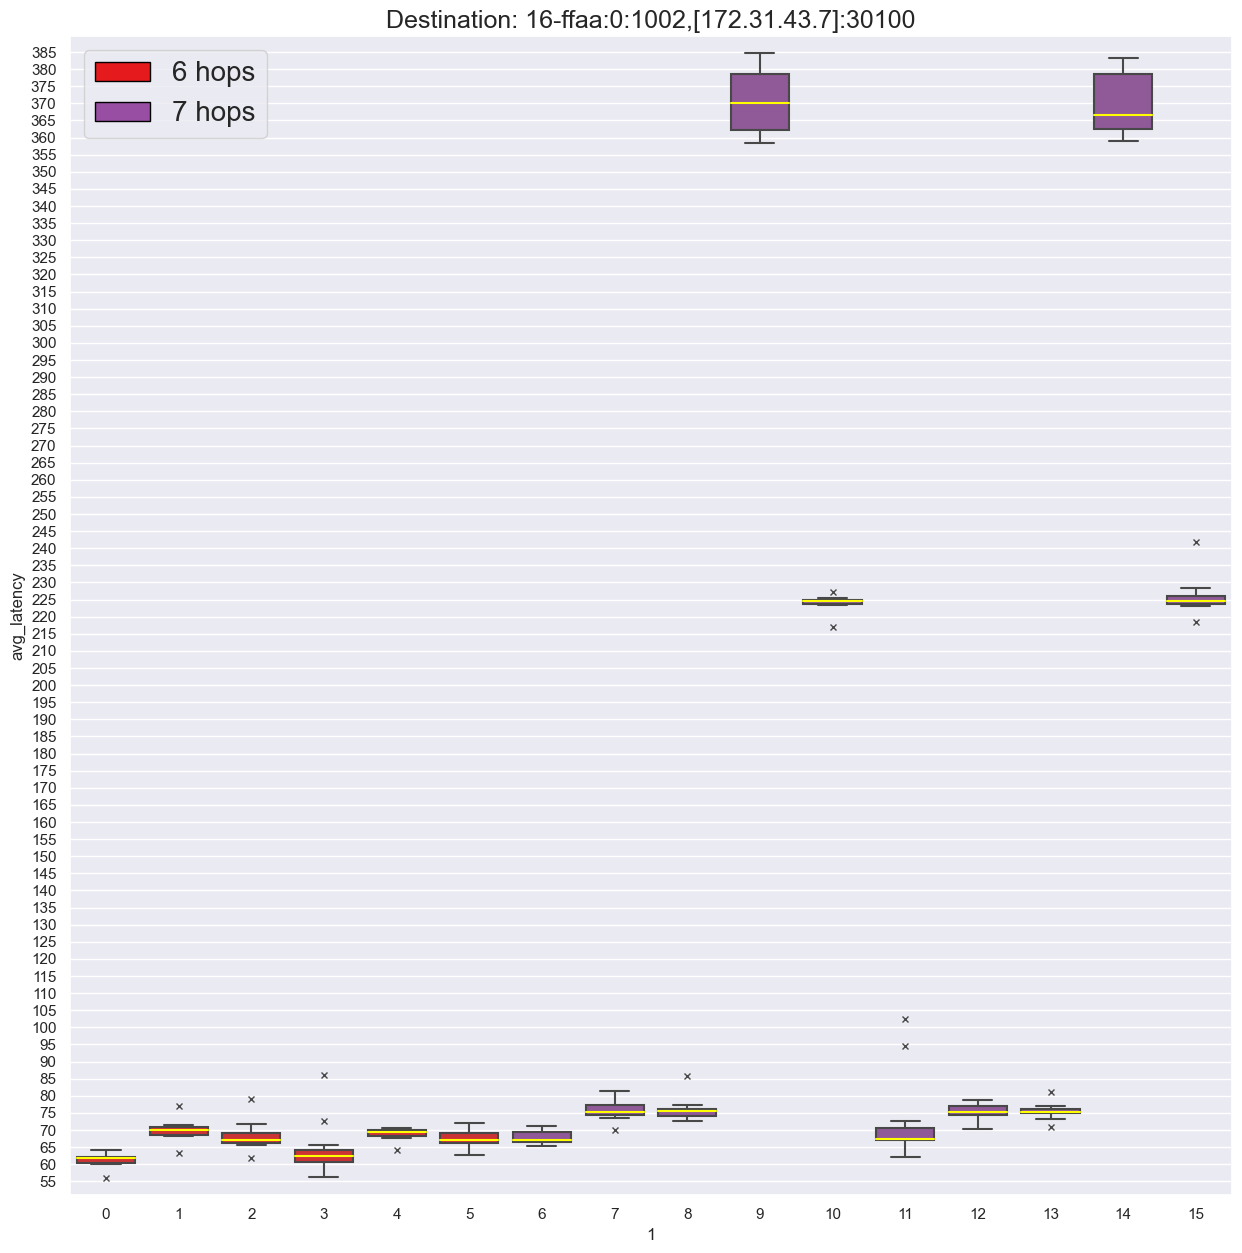

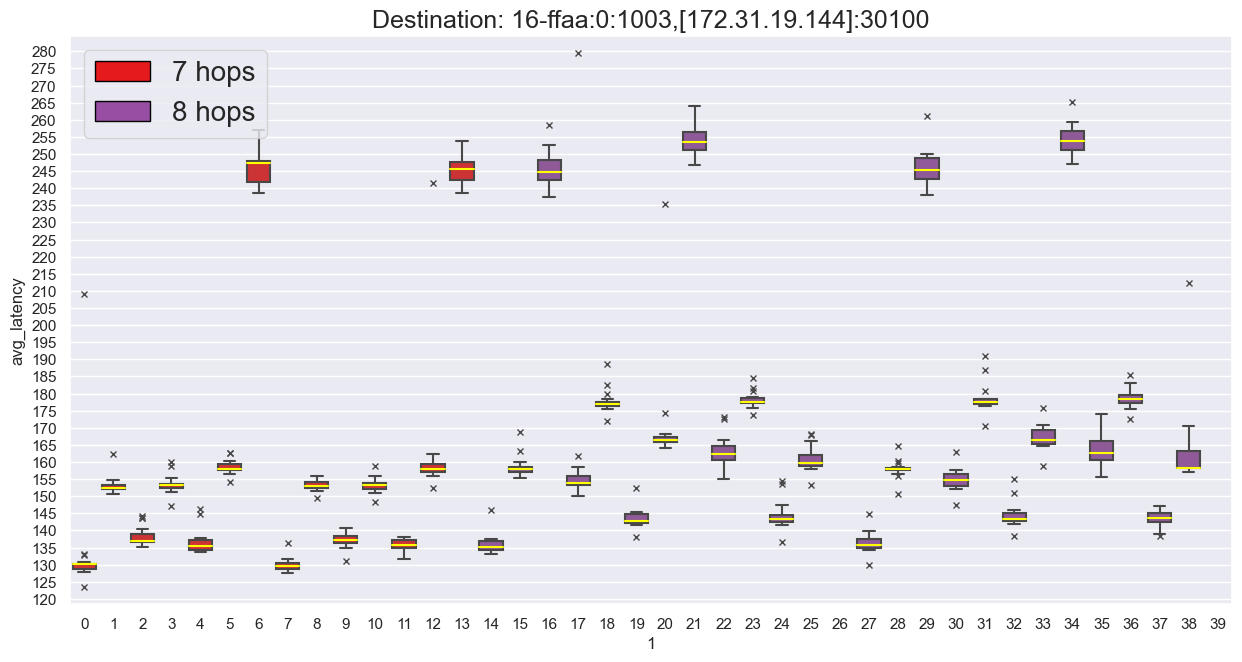

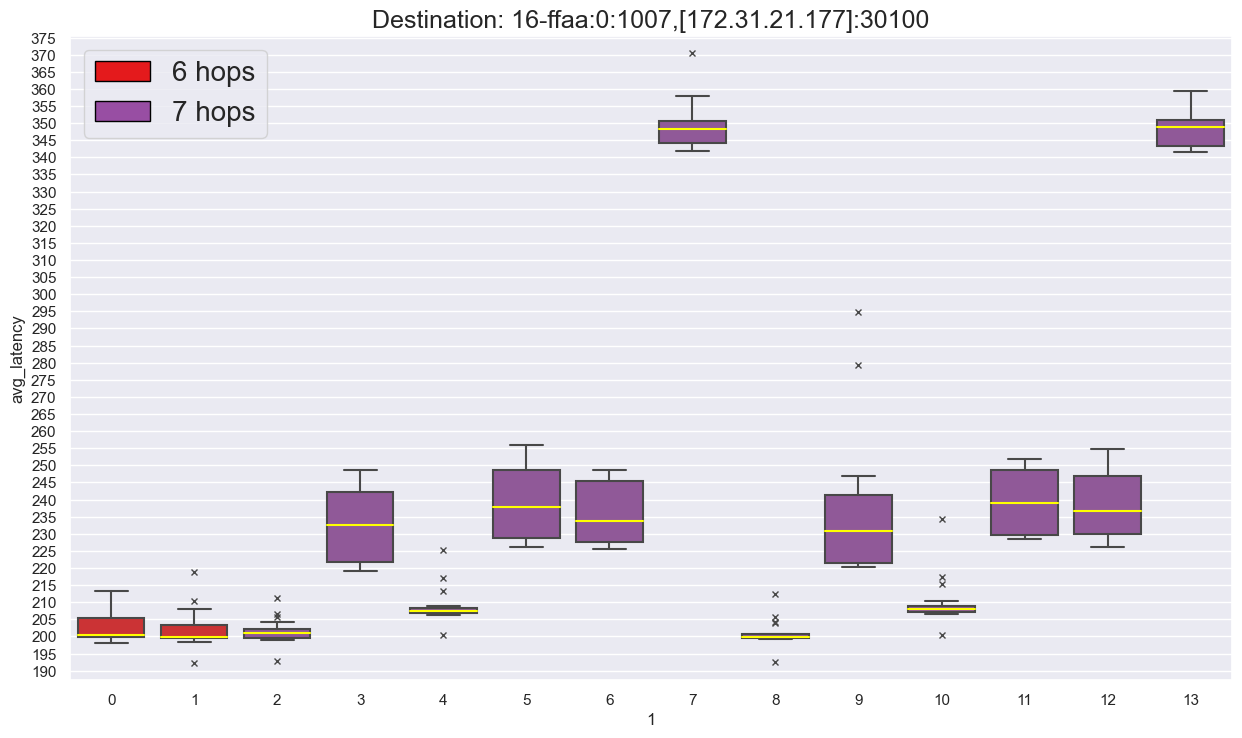

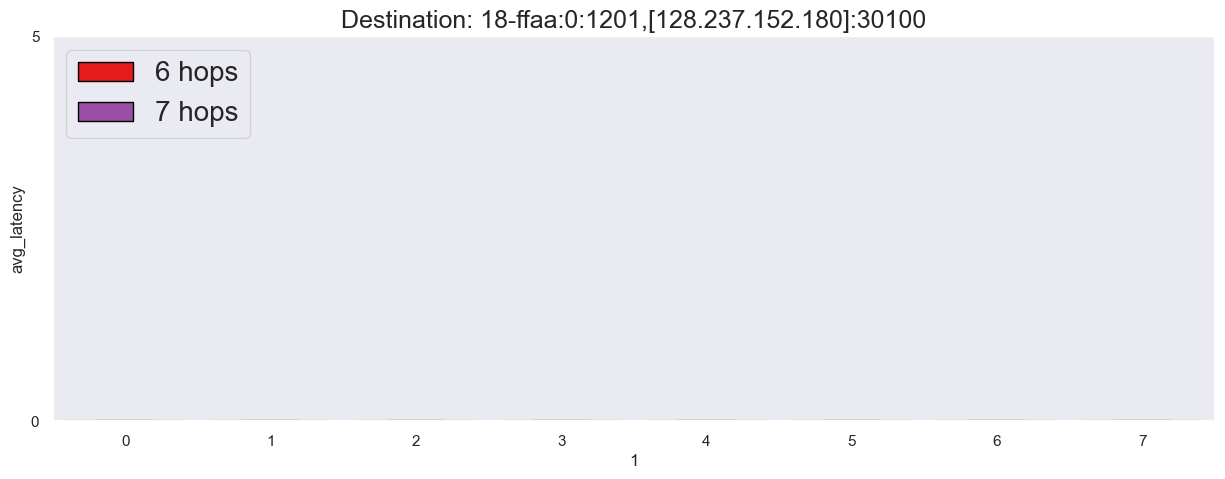

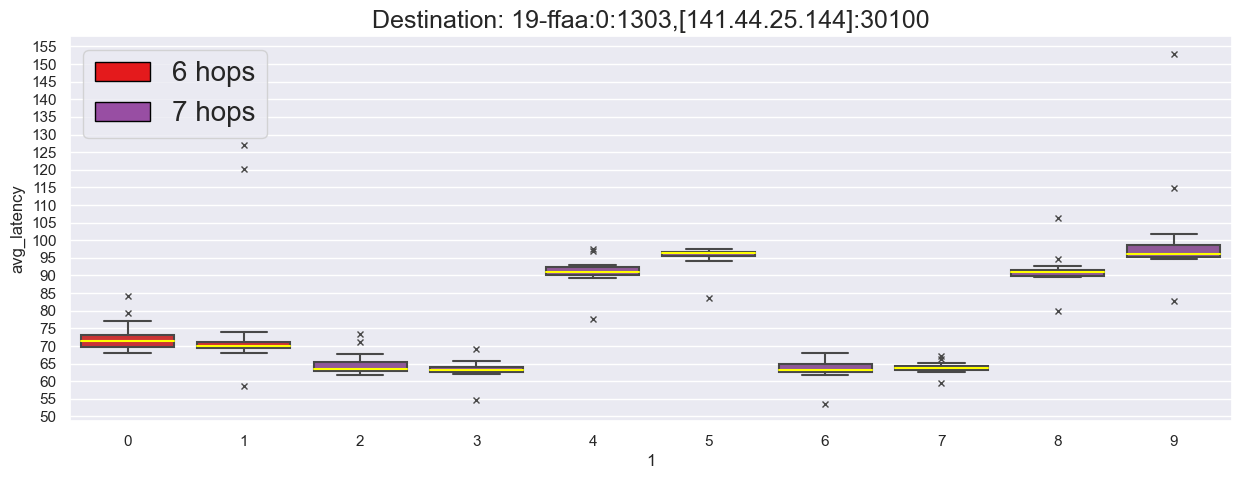

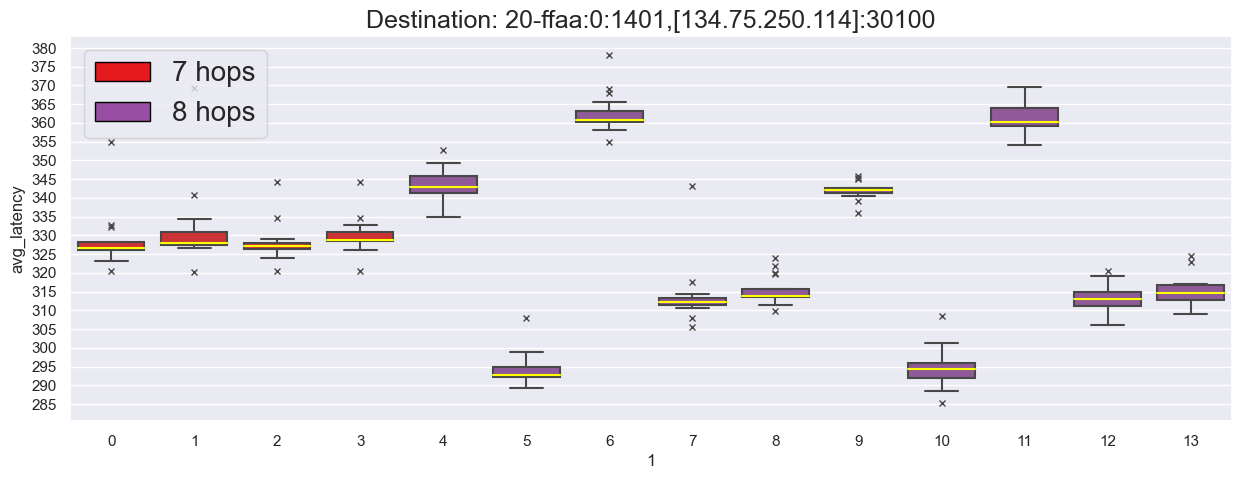

In [82]:
# # THIS IS THE CODE FOR THE PLOT OF THE AVERAGE LATENCY FOR EACH PATH FOR EACH DESTINATION. (WHISKER PLOT)

custom_ticks = []

for i in range(0, 400, 5):
    custom_ticks.append(i)

# Iterate over destinations and create a graph for each
# Iterate over destinations and create a graph for each
for destination in destinations:
    min_hops = df[df['_id'].str.startswith(destination)]['hops_number'].min()

    # Filter the DataFrame for the current destination and minimum number of hops +1 
    data = df[df['_id'].str.startswith(destination) & (df['hops_number'] <= min_hops+1)]

    min_latency = data['avg_latency'].min()
    max_latency = data[data['avg_latency'] <= 400]['avg_latency'].max()
    
    lower_bound = max(0, min_latency-5)
    upper_bound = min(400, max_latency+5)

    # print(max_latency)

    graph_height = upper_bound - lower_bound
    
    graph_height = graph_height/22.5 if not (graph_height/22.5) - 5 <= 0 else 5

    # Create a new figure for each destination
    fig, ax = plt.subplots(figsize=(15, graph_height))

    ax.set_yticks(custom_ticks, [str(tick) for tick in custom_ticks])
    ax.set_xlabel("PathID")
    ax.set_ylabel("Average Latency (ms)")

    ax.set_ylim([lower_bound, upper_bound])

    # Gets the source address of the current destination
    server = servers_df[servers_df['_id'] == int(destination)]['source_address'].iloc[0]

    # Create a sub DataFrame with all the ids for the current destination
    sub_df = [d for i,d in enumerate(data['_id'].unique())]

    # Create a list of colors for each pathID in the current destination
    box_color = [data[data['_id'] == id]['color'].iloc[0] for id in sub_df]

    # Create a dictionary mapping colors to number of hops
    color_hops_dict = {color: data[data['color'] == color]['hops_number'].iloc[0] for color in set(box_color)}

    sorted_color_hops_dict = {k: v for k, v in sorted(color_hops_dict.items(), key=lambda item: item[1])}

    # Create the whisker plot for the current destination
    sns.boxplot(data=data, x=data['_id'].str.split('_', expand=True)[1], y="avg_latency", palette=box_color, flierprops={"marker": "x"}, medianprops={"color" : "yellow"}, ax=ax)

    # Create a custom legend using the unique colors in the box_color list
    legend_handles = [mpatches.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black') for color in sorted_color_hops_dict.keys()]

    legend_labels = [f"{sorted_color_hops_dict[color]} hops" for color in set(sorted_color_hops_dict.keys())]
    legend_labels.sort(key=lambda x: int(x.split()[0]))

    ax.legend(legend_handles, legend_labels, loc='upper left', prop={'size': 20})  # Add the legend to the subplot

    ax.set_title(f"Destination: {server}", fontsize=18)  # Set the title for the subplot

    # Show the current figure
    plt.show()

In [83]:
#Creating a dictionary with the number of destinations for each number of hops

hops_destinations = {}

real_min = -1
higher_min = -1

num_dest = len(destinations)
for destination in destinations:
    min_hops = df[df['_id'].str.startswith(destination)]['hops_number'].min()
    if min_hops < real_min or real_min == -1:
        real_min = min_hops
    if min_hops > higher_min or higher_min == -1:
        higher_min = min_hops
    if min_hops in hops_destinations:
        hops_destinations[min_hops] = int(hops_destinations.get(min_hops, 0) + 1)
    else:
        hops_destinations[min_hops] = int(1)

list_of_hops = [i for i in range(real_min, higher_min+1, 1)]


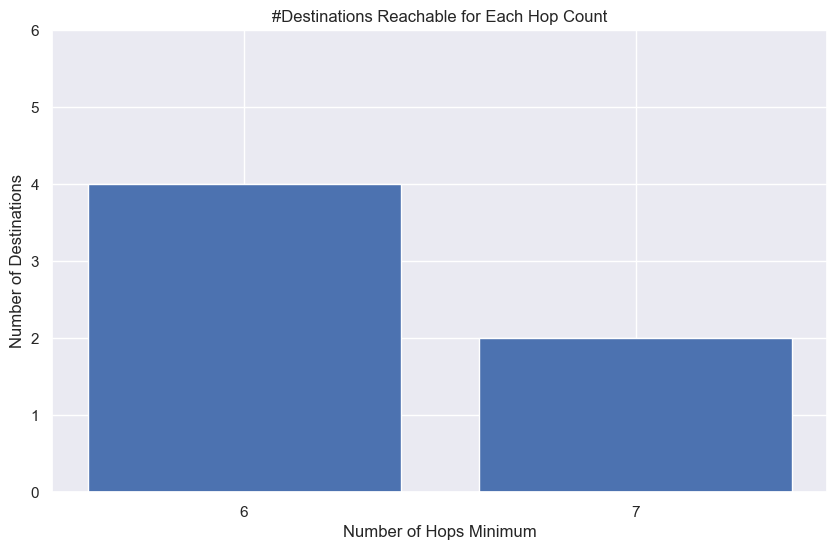

In [84]:
# Create a bar chart with #destination reachable for each hop count
plt.figure(figsize=(10, 6))
plt.bar(hops_destinations.keys(), hops_destinations.values())
plt.xticks(list_of_hops, [str(hops) for hops in list_of_hops])
plt.yticks([i for i in range(0, num_dest+1, 1)])
# Set the labels and title
plt.xlabel('Number of Hops Minimum')
plt.ylabel('Number of Destinations')
plt.title('#Destinations Reachable for Each Hop Count')

# Show the plot
plt.show()


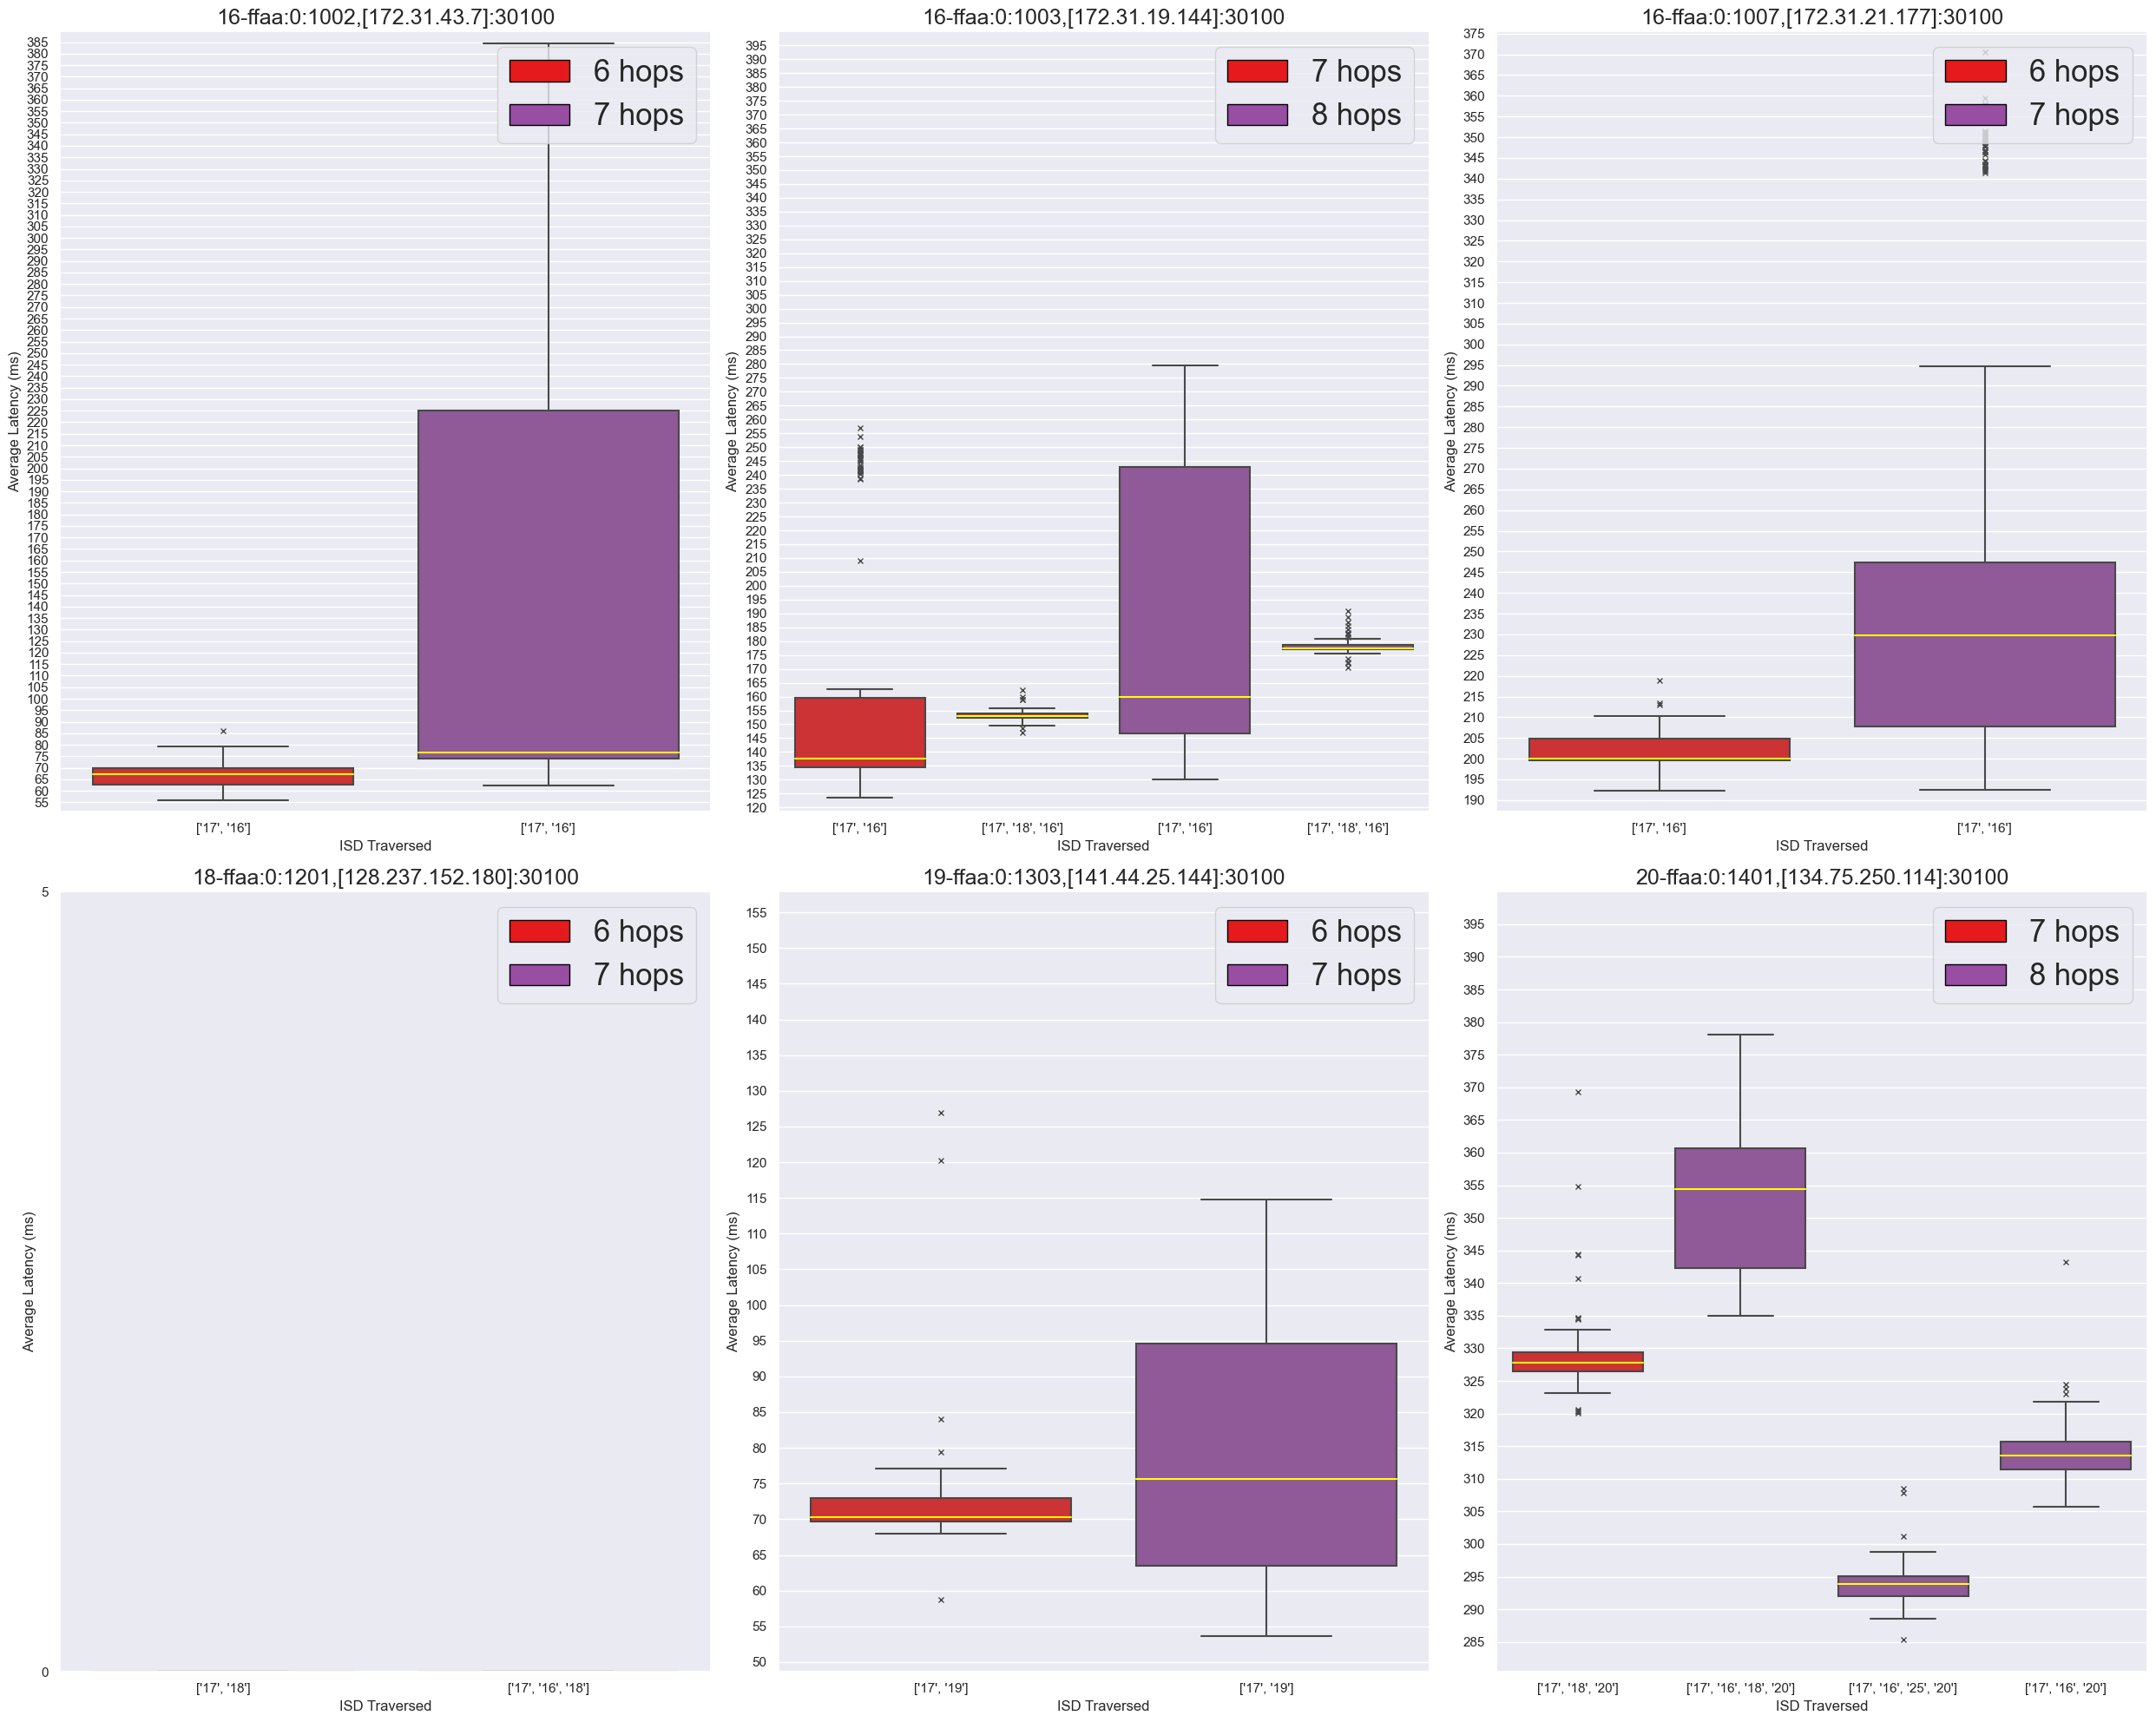

In [85]:
#Latency measured per ISD, grouped by hop count, destination fixed

# Create subplots with 2 rows and 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 20))


# Filter the DataFrame to include only the necessary columns
filtered_df = df[['_id', 'avg_latency', 'isolated_domains', 'hops_number', 'color']]

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()
custom_ticks = []

for i in range(0, 400, 5):
    custom_ticks.append(i)

# Iterate over destinations and create a graph for each
for i, destination in enumerate(destinations):
    ax = axes[i]  # Get the current subplot
    ax.set_yticks(custom_ticks, [str(tick) for tick in custom_ticks])
    
    min_hops = filtered_df[filtered_df['_id'].str.startswith(destination)]['hops_number'].min()

    # Filter the DataFrame for the current destination and minimum number of hops 
    data = filtered_df[filtered_df['_id'].str.startswith(destination) & (filtered_df['hops_number'] <= min_hops+1)]

    #print(data)
    data = data.copy()
    
    data['isolated_domains'] = data['isolated_domains'].apply(tuple)
    data['x_value'] = data.apply(lambda row: (row['isolated_domains'], row['hops_number']), axis=1)

    # data = data[~data['_id'].isin(["1_9", "1_10", "1_14", "1_15"])]
    # print(data)

    # Create a sub DataFrame with all the isds for the current destination
    sub_df = [d for _,d in enumerate(data['x_value'].unique())]

    #print(sub_df)
    # Create a list of colors, It retrieves the color of the ISD with the minimum number of hops
    box_color = [data[data['x_value'] == domain]['color'].iloc[0] for domain in sub_df]

    #print(box_color)

    # Create a dictionary mapping colors to number of hops
    color_hops_dict = {color: data[data['color'] == color]['hops_number'].iloc[0] for color in set(box_color) if color is not None and not data[data['color'] == color].empty}

    #print(color_hops_dict)

    # Create the whisker plot for the current destination
    sns.boxplot(data=data, x=data['x_value'], y="avg_latency", palette=box_color, flierprops={"marker": "x"}, medianprops={"color" : "yellow"}, ax=ax)
    
    sorted_color_hops_dict = {k: v for k, v in sorted(color_hops_dict.items(), key=lambda item: item[1])}
  
    # Create a custom legend using the unique colors in the box_color list
    legend_handles = [mpatches.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black') for color in sorted_color_hops_dict.keys()]

    legend_labels = [f"{sorted_color_hops_dict[color]} hops" for color in set(sorted_color_hops_dict.keys())]
    legend_labels.sort(key=lambda x: int(x.split()[0]))
    
    ax.legend(legend_handles, legend_labels, loc='upper right', prop={'size': 25})  # Add the legend to the subplot
    ax.set_xlabel("ISD Traversed")
    ax.set_ylabel("Average Latency (ms)")
    
    min_latency = data['avg_latency'].min()
    max_latency = data['avg_latency'].max()

    ax.set_ylim([max(0, min_latency-5), min(400, max_latency+5)])

    # Gets the source address of the current destination
    server = servers_df[servers_df['_id'] == int(destination)]['source_address'].iloc[0]

    ax.set_title(f"{server}", fontsize=18)  # Set the title for the subplot

    ax.set_xticklabels([str(list(tick[0])) for tick in data['x_value'].unique()])

# Adjust the layout of the subplots
plt.tight_layout()
plt.show()


In [86]:
# Convert bw columns to numeric
df['avg_bandwidth_cs_MTU'] = pd.to_numeric(df['avg_bandwidth_cs_MTU'].str.replace('Mbps', ''), errors='coerce').fillna(0)
df['avg_bandwidth_sc_MTU'] = pd.to_numeric(df['avg_bandwidth_sc_MTU'].str.replace('Mbps', ''), errors='coerce').fillna(0)
df['avg_bandwidth_cs_64'] = pd.to_numeric(df['avg_bandwidth_cs_64'].str.replace('Mbps', ''), errors='coerce').fillna(0)
df['avg_bandwidth_sc_64'] = pd.to_numeric(df['avg_bandwidth_sc_64'].str.replace('Mbps', ''), errors='coerce').fillna(0)


In [87]:
# Convert bw columns to numeric
dfbw['avg_bandwidth_cs_MTU'] = pd.to_numeric(dfbw['avg_bandwidth_cs_MTU'].str.replace('Mbps', ''), errors='coerce').fillna(0)
dfbw['avg_bandwidth_sc_MTU'] = pd.to_numeric(dfbw['avg_bandwidth_sc_MTU'].str.replace('Mbps', ''), errors='coerce').fillna(0)
dfbw['avg_bandwidth_cs_64'] = pd.to_numeric(dfbw['avg_bandwidth_cs_64'].str.replace('Mbps', ''), errors='coerce').fillna(0)
dfbw['avg_bandwidth_sc_64'] = pd.to_numeric(dfbw['avg_bandwidth_sc_64'].str.replace('Mbps', ''), errors='coerce').fillna(0)


In [88]:
# Group by destination and pathID, and compute the mean of each bandwidth column
# grouped_df = df.groupby(['_id', 'hops_number', 'color'])[['avg_bandwidth_cs_MTU', 'avg_bandwidth_sc_MTU', 'avg_bandwidth_cs_64', 'avg_bandwidth_sc_64']].mean().reset_index().sort_values(by='_id', key=lambda col: col.str.replace('_', '').astype(int))
# print(grouped_df)
custom_ticks = []
value = 0

while value < 40:
    custom_ticks.append(value)
    value += 2.5

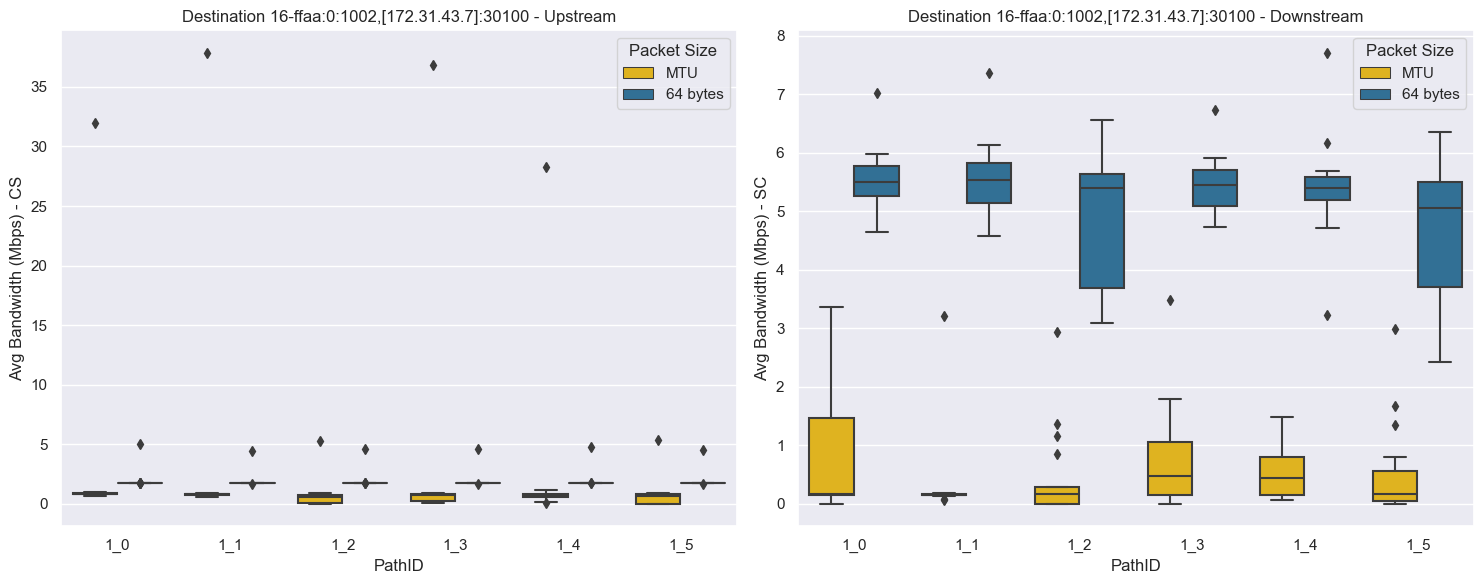

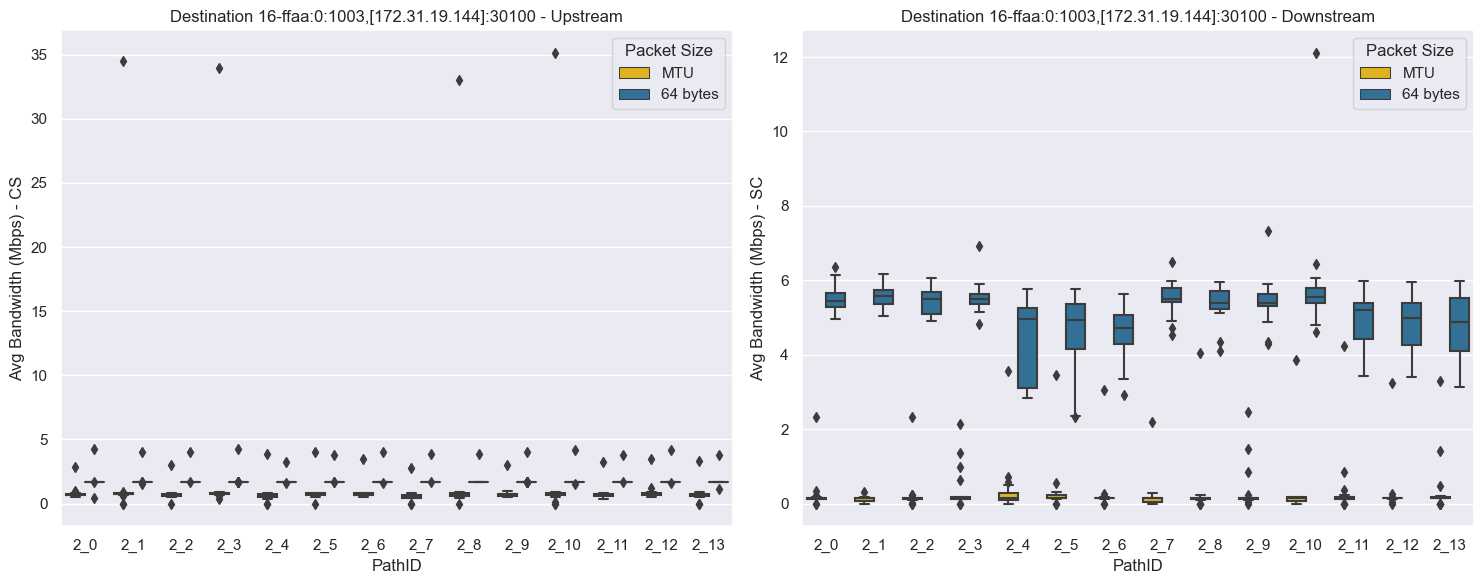

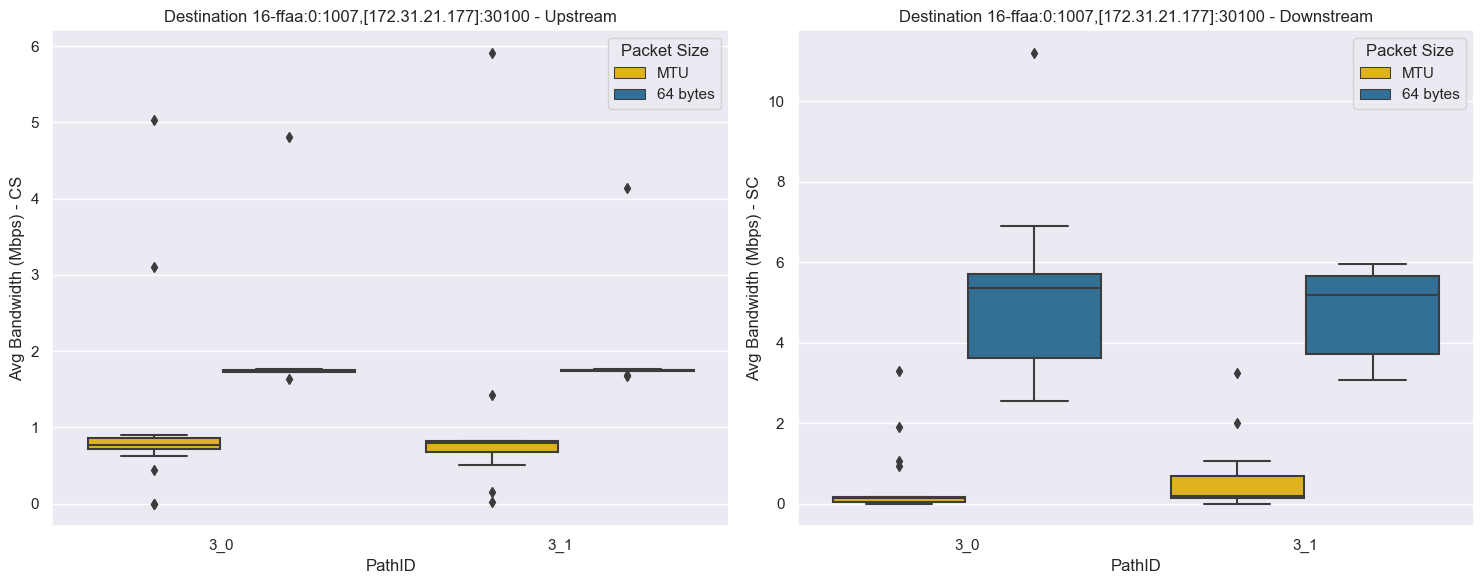

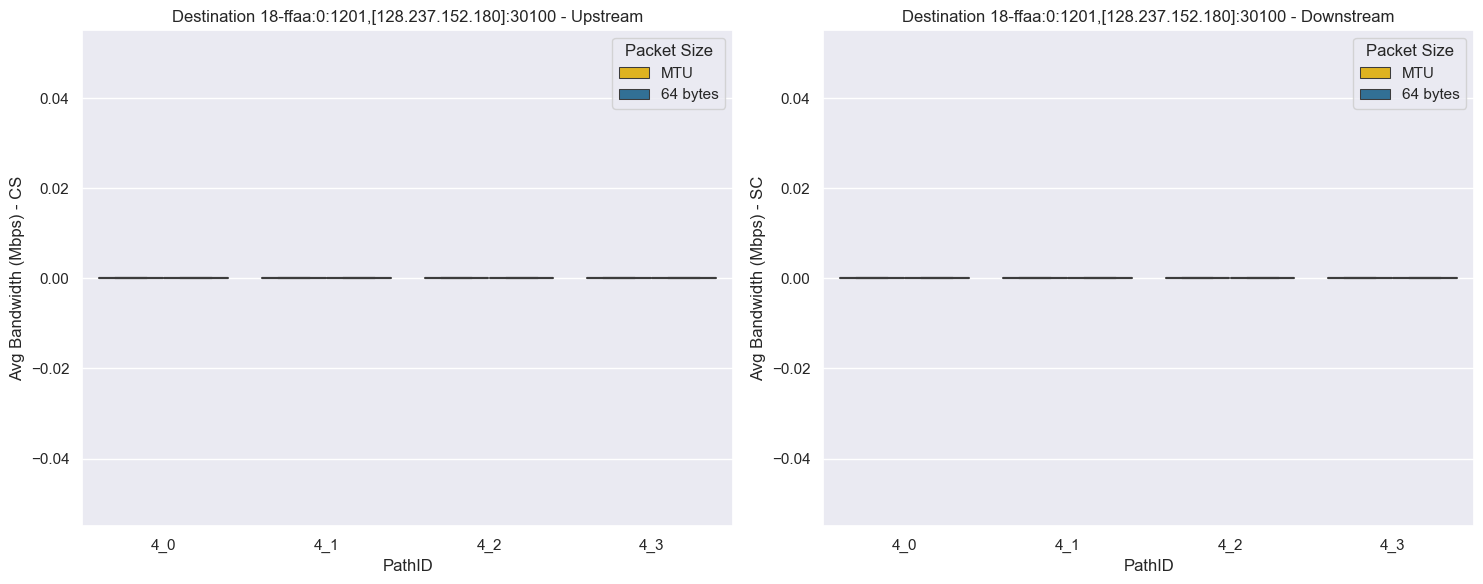

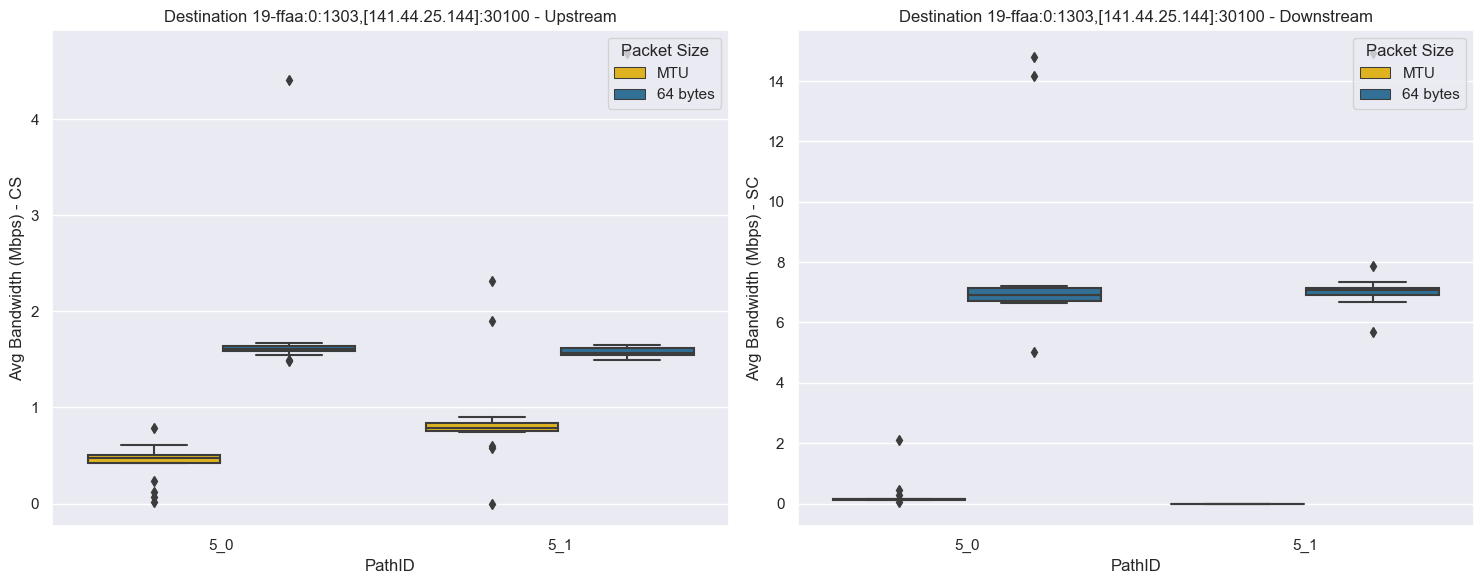

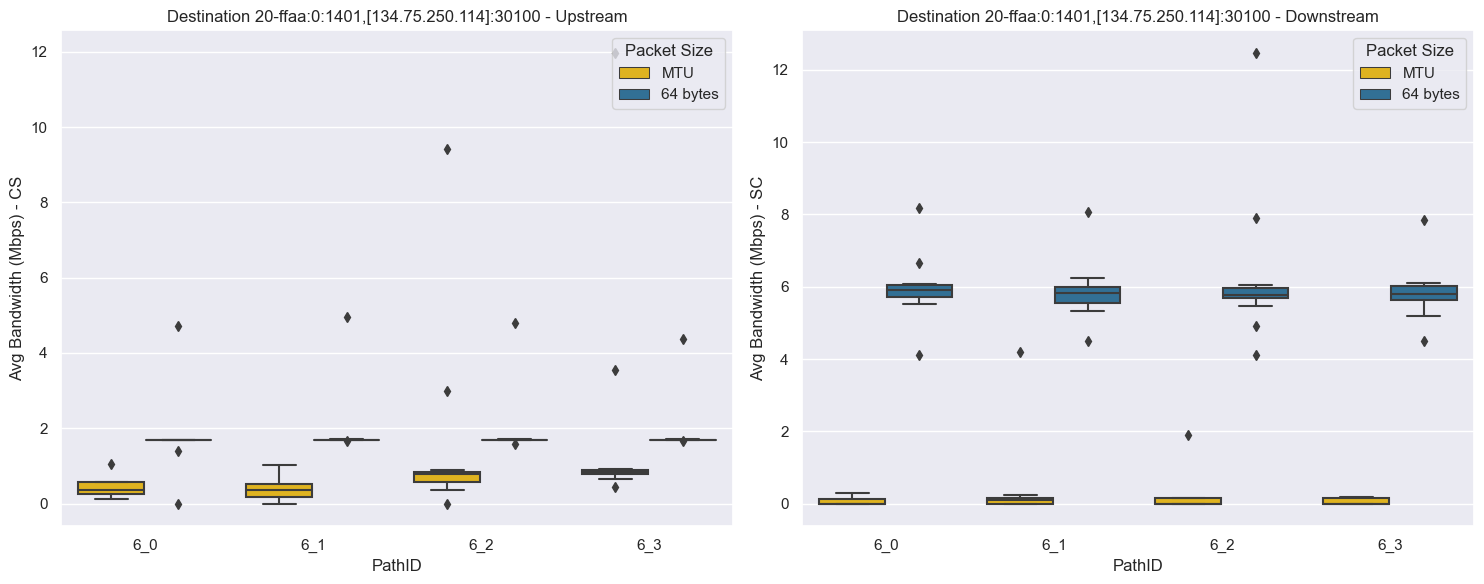

In [89]:
#PLOT FOR THE BANDWIDTH TESTS WITH REQUIRED BW OF 150Mbps (64 BYTES BETTER THAN MTU)

import matplotlib.pyplot as plt
import seaborn as sns

# Iterate over the destinations and create a separate plot for each destination
for destination in destinations:
    # Get the data for the current destination
    min_hops = df[df['_id'].str.startswith(destination)]['hops_number'].min()
    data = df[df['_id'].str.startswith(destination) & (df['hops_number'] == min_hops)]

    # Create the figure for the current destination
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # Create the subplots for upstream and downstream bandwidth
    ax1 = axes[0]
    ax2 = axes[1]

    # Concatenate the data for MTU and 64, and create a new 'type' column
    data_mtu = data[['avg_bandwidth_cs_MTU', 'avg_bandwidth_cs_64', '_id']].melt(value_name='avg_bandwidth', id_vars='_id', var_name='type', ignore_index=True)
    data_64 = data[['avg_bandwidth_sc_MTU', 'avg_bandwidth_sc_64', '_id']].melt(value_name='avg_bandwidth', id_vars='_id', var_name='type', ignore_index=True)

    # Create Gaussians for MTU packet size
    sns.boxplot(data=data_mtu, x='_id', y='avg_bandwidth', hue='type', ax=ax1, palette={"avg_bandwidth_cs_MTU": "#ffc400", "avg_bandwidth_cs_64": "#2274a5"})
    sns.boxplot(data=data_64, x='_id', y='avg_bandwidth', hue='type', ax=ax2, palette={"avg_bandwidth_sc_MTU": "#ffc400", "avg_bandwidth_sc_64": "#2274a5"})

    # Gets the source address of the current destination
    server = servers_df[servers_df['_id'] == int(destination)]['source_address'].iloc[0]

    # Set the titles and labels
    ax1.set_title(f"Destination {server} - Upstream")
    ax2.set_title(f"Destination {server} - Downstream")

    ax1.set_ylabel("Avg Bandwidth (Mbps) - CS")
    ax2.set_ylabel("Avg Bandwidth (Mbps) - SC")

    ax1.set_xlabel("PathID")
    ax2.set_xlabel("PathID")

    # Add a legend
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles=handles, labels=['MTU', '64 bytes'], title='Packet Size', loc='upper right')
    ax2.legend(handles=handles, labels=['MTU', '64 bytes'], title='Packet Size', loc='upper right')

    # Adjust the layout of the subplots
    plt.tight_layout()

    # Close the current figure to create a new one for the next destination
    plt.savefig(f"../../graphs/Bandwidth Whiskers/bw_destination_{destination}.png")
    plt.show()    
    plt.close()


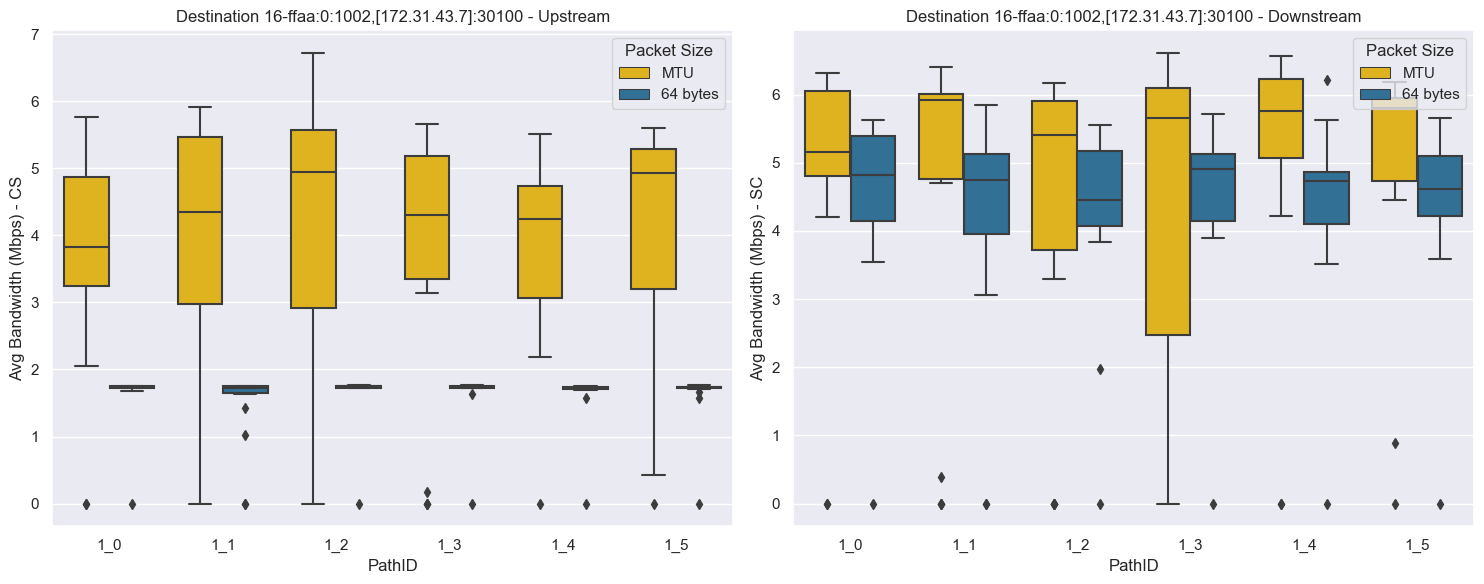

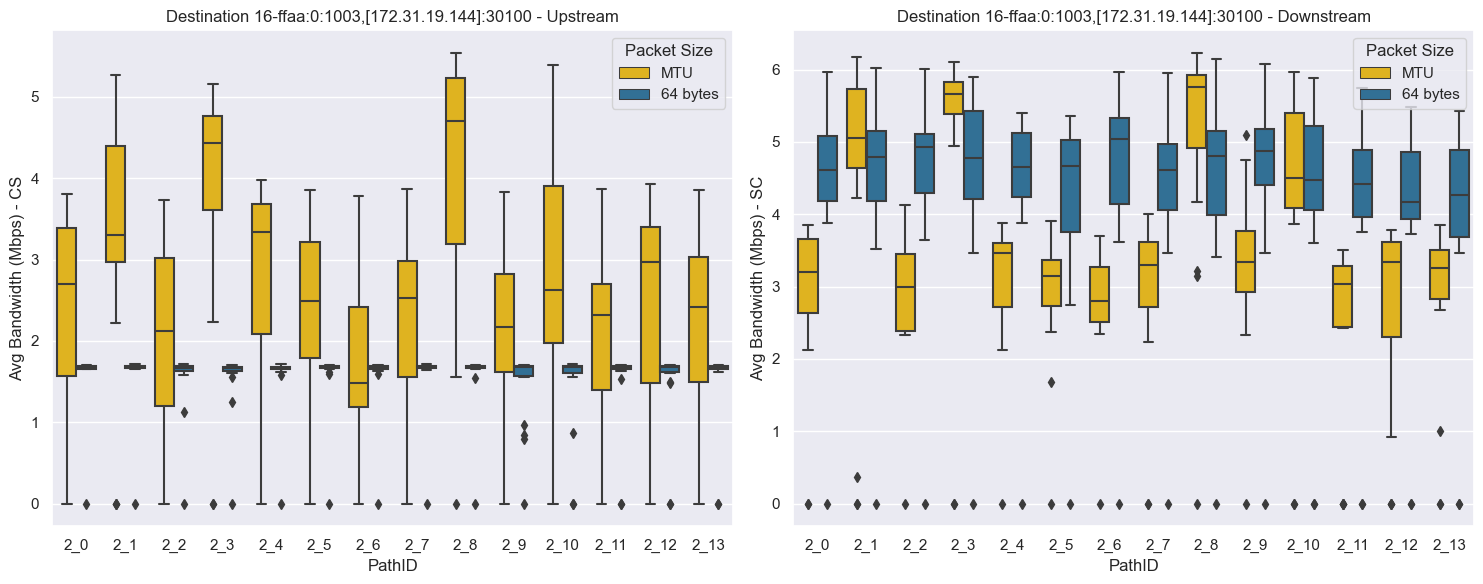

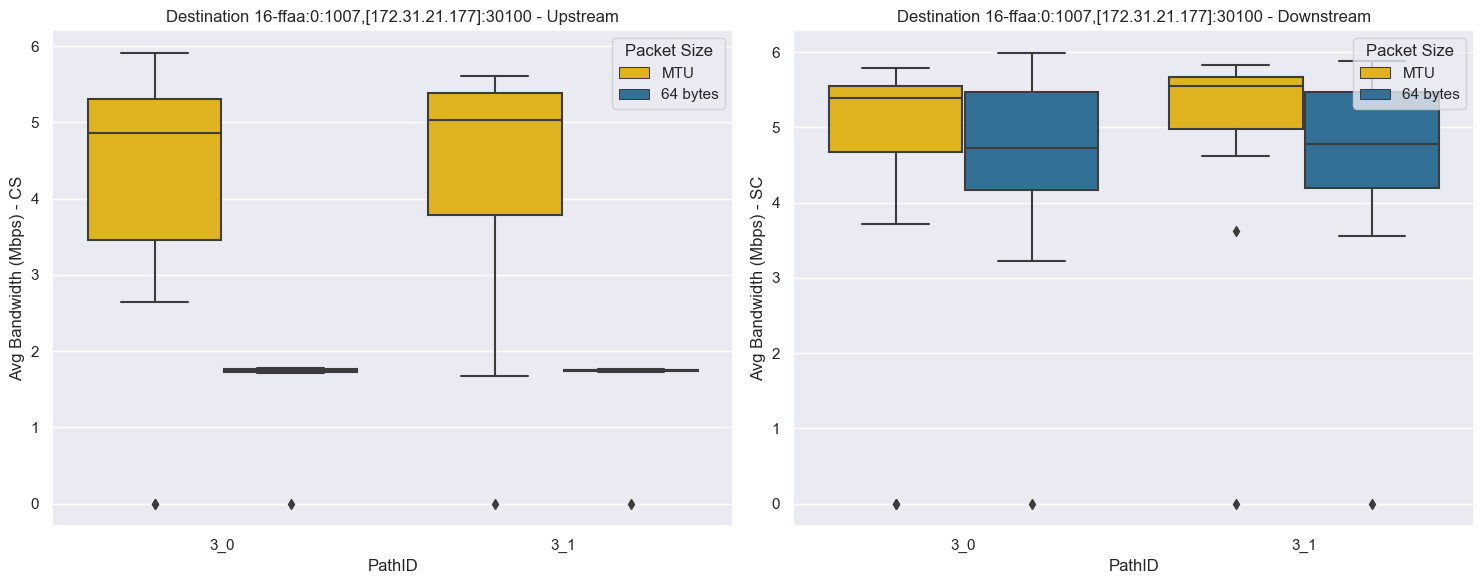

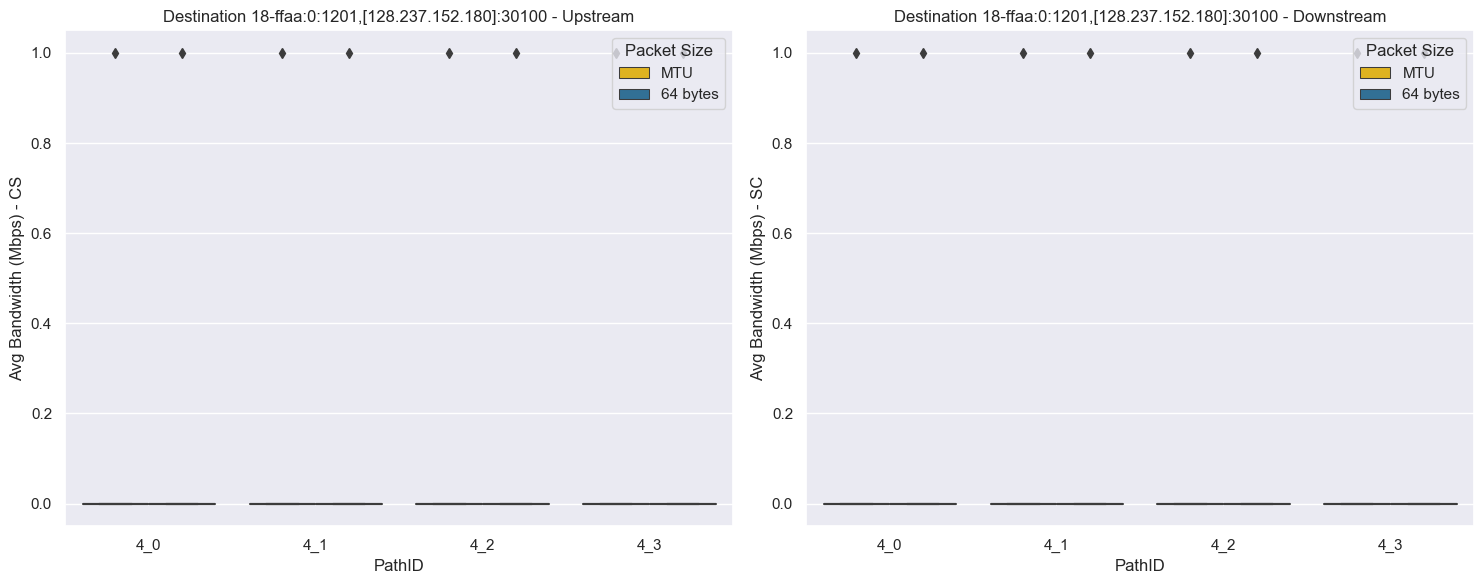

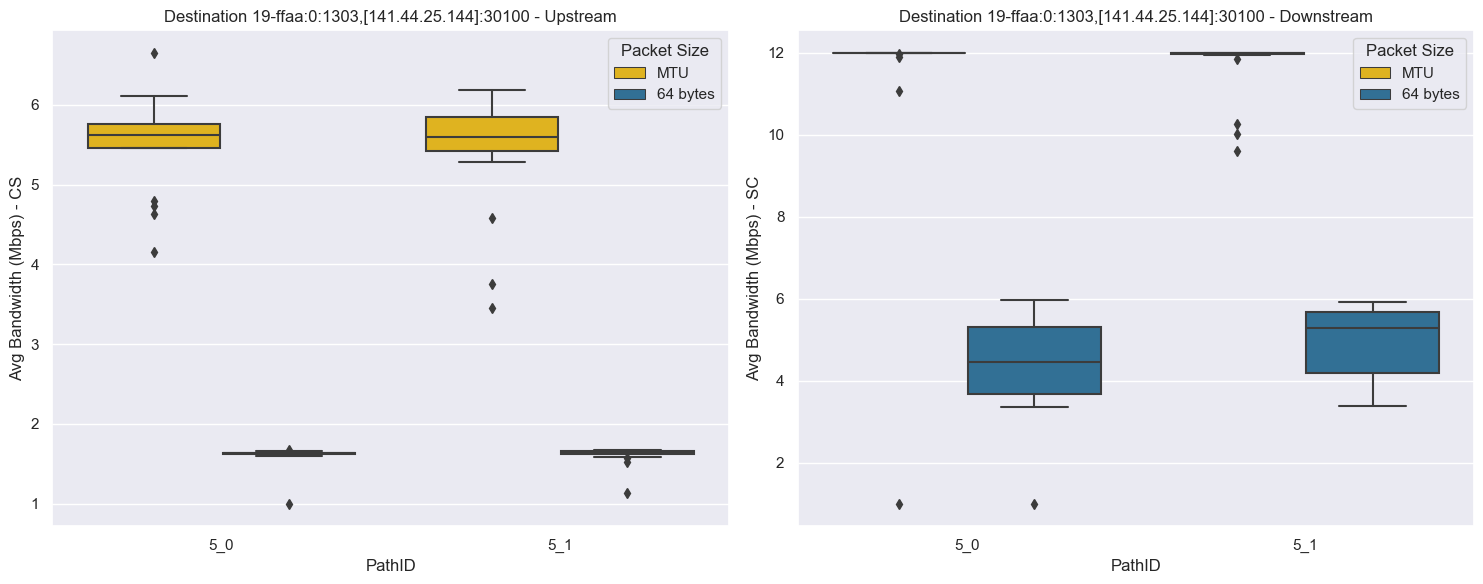

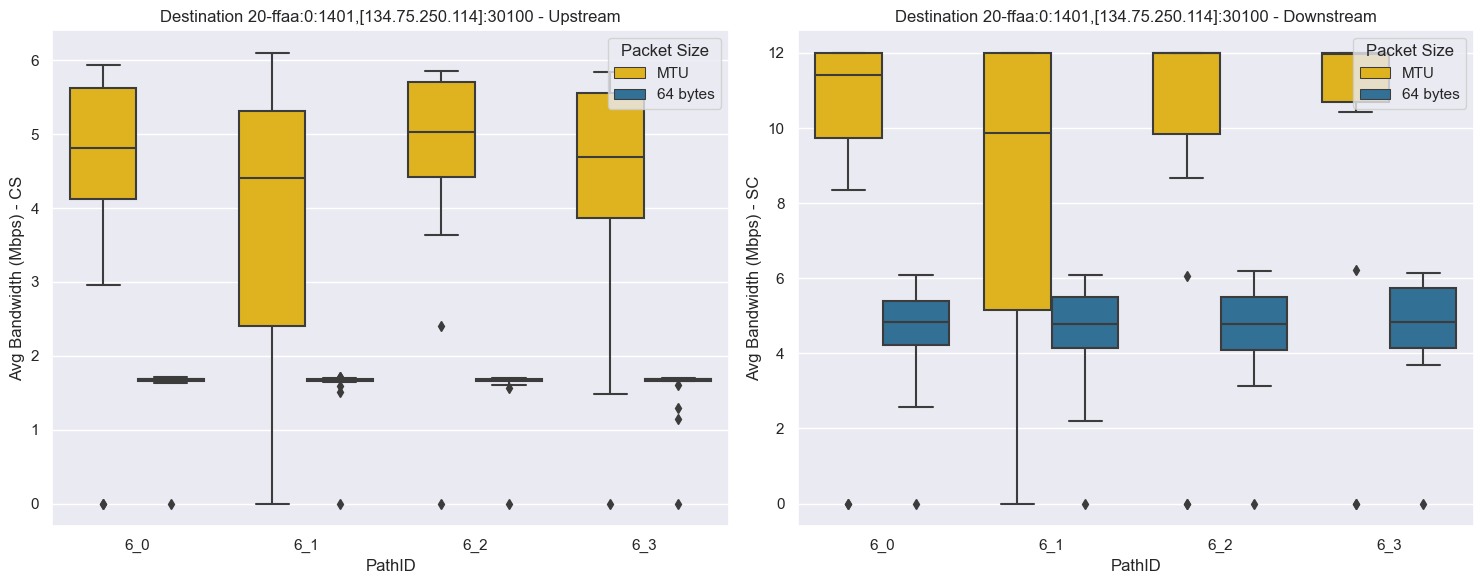

In [90]:
#PLOT FOR THE BANDWIDTH TESTS WITH REQUIRED BW OF 12Mbps (MTU BETTER THAN 64 BYTES)

# Iterate over the destinations and create a separate plot for each destination
for destination in destinations:
    # Get the data for the current destination
    min_hops = dfbw[dfbw['_id'].str.startswith(destination)]['hops_number'].min()
    data = dfbw[dfbw['_id'].str.startswith(destination) & (dfbw['hops_number'] == min_hops)]

    # Create the figure for the current destination
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # Create the subplots for upstream and downstream bandwidth
    ax1 = axes[0]
    ax2 = axes[1]

    # Concatenate the data for MTU and 64, and create a new 'type' column
    data_mtu = data[['avg_bandwidth_cs_MTU', 'avg_bandwidth_cs_64', '_id']].melt(value_name='avg_bandwidth', id_vars='_id', var_name='type', ignore_index=True)
    data_64 = data[['avg_bandwidth_sc_MTU', 'avg_bandwidth_sc_64', '_id']].melt(value_name='avg_bandwidth', id_vars='_id', var_name='type', ignore_index=True)

    # Create Gaussians for MTU packet size
    sns.boxplot(data=data_mtu, x='_id', y='avg_bandwidth', hue='type', ax=ax1, palette={"avg_bandwidth_cs_MTU": "#ffc400", "avg_bandwidth_cs_64": "#2274a5"})
    sns.boxplot(data=data_64, x='_id', y='avg_bandwidth', hue='type', ax=ax2, palette={"avg_bandwidth_sc_MTU": "#ffc400", "avg_bandwidth_sc_64": "#2274a5"})

    # Gets the source address of the current destination
    server = servers_df[servers_df['_id'] == int(destination)]['source_address'].iloc[0]

    # Set the titles and labels
    ax1.set_title(f"Destination {server} - Upstream")
    ax2.set_title(f"Destination {server} - Downstream")

    ax1.set_ylabel("Avg Bandwidth (Mbps) - CS")
    ax2.set_ylabel("Avg Bandwidth (Mbps) - SC")

    ax1.set_xlabel("PathID")
    ax2.set_xlabel("PathID")

    # Add a legend
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles=handles, labels=['MTU', '64 bytes'], title='Packet Size', loc='upper right')
    ax2.legend(handles=handles, labels=['MTU', '64 bytes'], title='Packet Size', loc='upper right')

    # Adjust the layout of the subplots
    plt.tight_layout()

    # Close the current figure to create a new one for the next destination
    #plt.savefig(f"../../graphs/Bandwidth Whiskers/bw_destination_{destination}.png")
    plt.show()    
    plt.close()


In [91]:
dflss['avg_loss'] = pd.to_numeric(dflss['avg_loss'].str.replace('%', ''), errors='coerce').fillna(0)

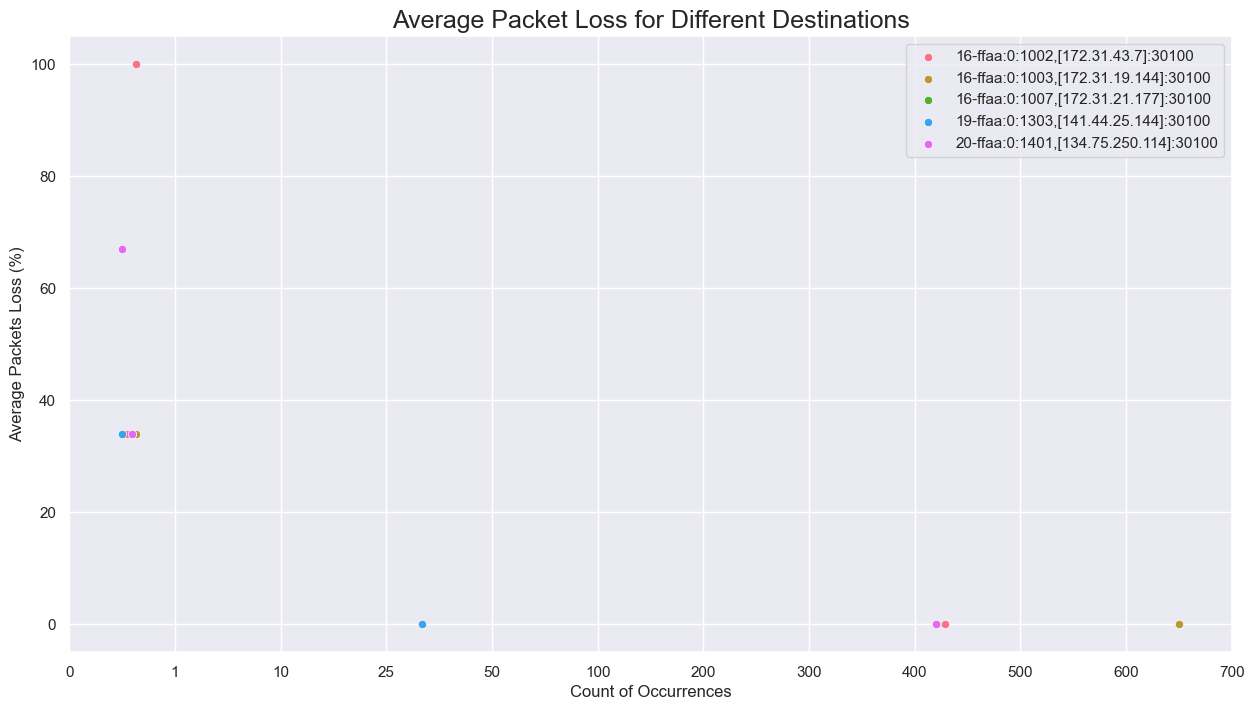

In [15]:
# Define plot for the average packet loss for each destination
fig, ax = plt.subplots(figsize=(15, 8))

# Create a custom color palette with unique colors for each destination
color_palette = sns.color_palette("husl", len(destinations))
data = df.copy()
# Iterate over destinations and create a scatter plot for each
for i, destination in enumerate(destinations):
    if destination == '4':
        continue
    # Filter the DataFrame for the current destination
    dest_data = data[data['_id'].str.startswith(destination)]
    
    # Count the occurrences for each loss percentage and create a new DataFrame
    loss_counts = dest_data['avg_loss'].value_counts().reset_index()

    loss_counts.columns = ['avg_loss', 'count']

    dest_addr = servers_df[servers_df['_id'] == int(destination)]['source_address'].iloc[0]
    # Plot the scatter plot for the current destination
    sns.scatterplot(data=loss_counts, x=loss_counts['count'], y="avg_loss", color=color_palette[i], ax=ax, label=dest_addr)

# Set the x-axis label to indicate the count of occurrences
ax.set_xlabel("Count of Occurrences")

# Set the y-axis label to show the Average Packet Loss
ax.set_ylabel("Average Packets Loss (%)")

# Set the title for the subplot
ax.set_title("Average Packet Loss for Different Destinations", fontsize=18)

# Define your custom scale for the x-axis
custom_ticks = [0, 1, 10, 25, 50, 100, 200, 300, 400, 500, 600, 700]
custom_labels = ['0', "1", "10", "25", "50", '100', '200', '300', '400', '500', '600', '700']

ax.set_xticks(custom_ticks)
ax.set_xticklabels(custom_ticks)
ax.xaxis.set_major_locator(ticker.LinearLocator(12, custom_ticks))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(custom_labels))

# Show the legend
ax.legend()

# Show the plot
plt.show()

     _id  avg_loss  count
0    1_0         0     55
1    1_0         4      3
2    1_0         7      1
3    1_1         0     55
4    1_1         4      1
5    1_1         7      1
6    1_1        20      1
7    1_1       100      1
26   1_2       100      2
25   1_2        14      1
24   1_2         7      1
23   1_2         0     55
29   1_3         7      1
28   1_3         4      1
27   1_3         0     55
30   1_3       100      2
31   1_4         0     57
33   1_4       100      1
32   1_4         4      1
36   1_5        10      2
35   1_5         4      1
34   1_5         0     55
37   1_5        34      1
39   1_6       100      2
38   1_6         0     57
42   1_7       100      2
41   1_7         4      1
40   1_7         0     56
44   1_8       100      2
43   1_8         0     57
45   1_9         0     55
47   1_9       100      2
46   1_9         4      2
8   1_10         0     56
9   1_10         4      2
10  1_10        17      1
13  1_11        10      1
11  1_11    

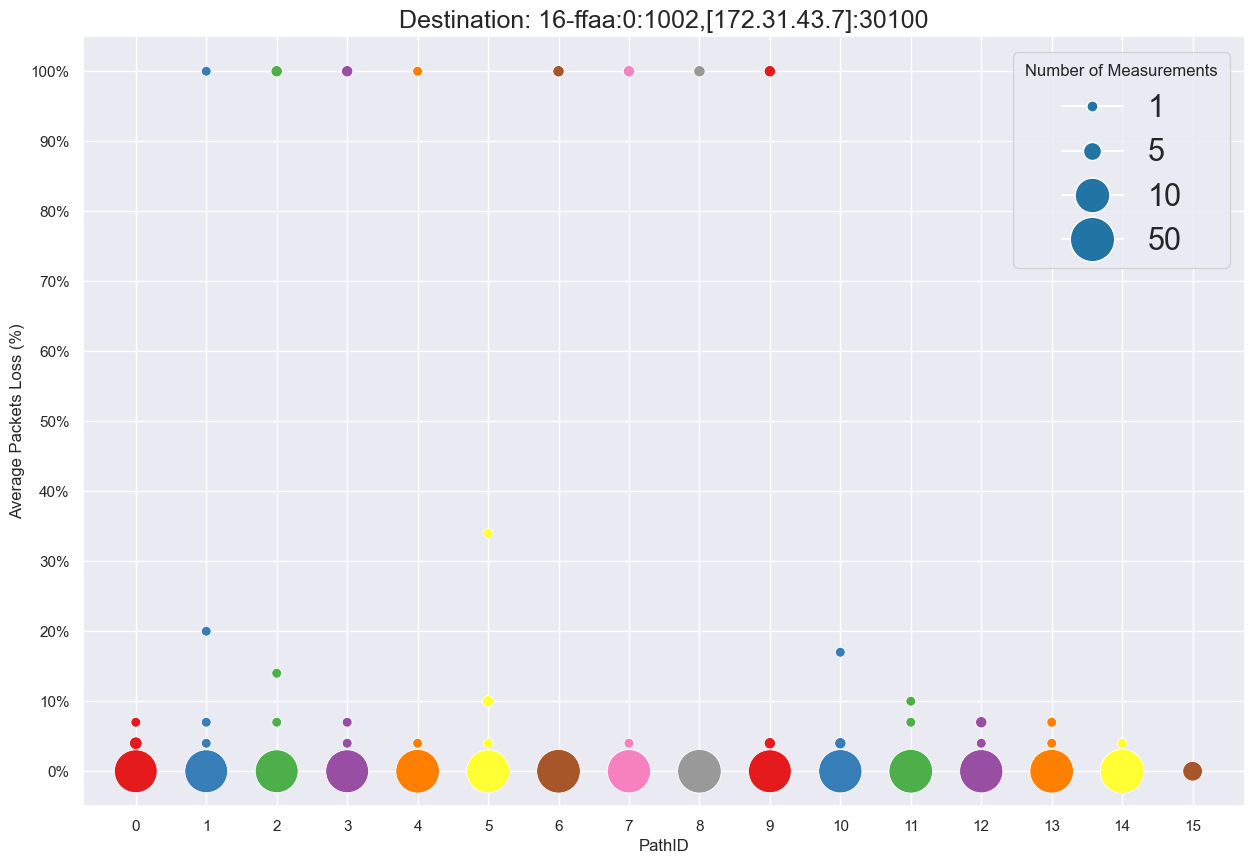

     _id  avg_loss  count
0    2_0         0     59
1    2_1         0     58
2    2_1         4      1
28   2_2         0     59
57   2_3         4      2
..   ...       ...    ...
78  2_38         7      2
76  2_38         0     56
77  2_38         4      1
79  2_39         0     57
80  2_39         7      2

[94 rows x 3 columns]


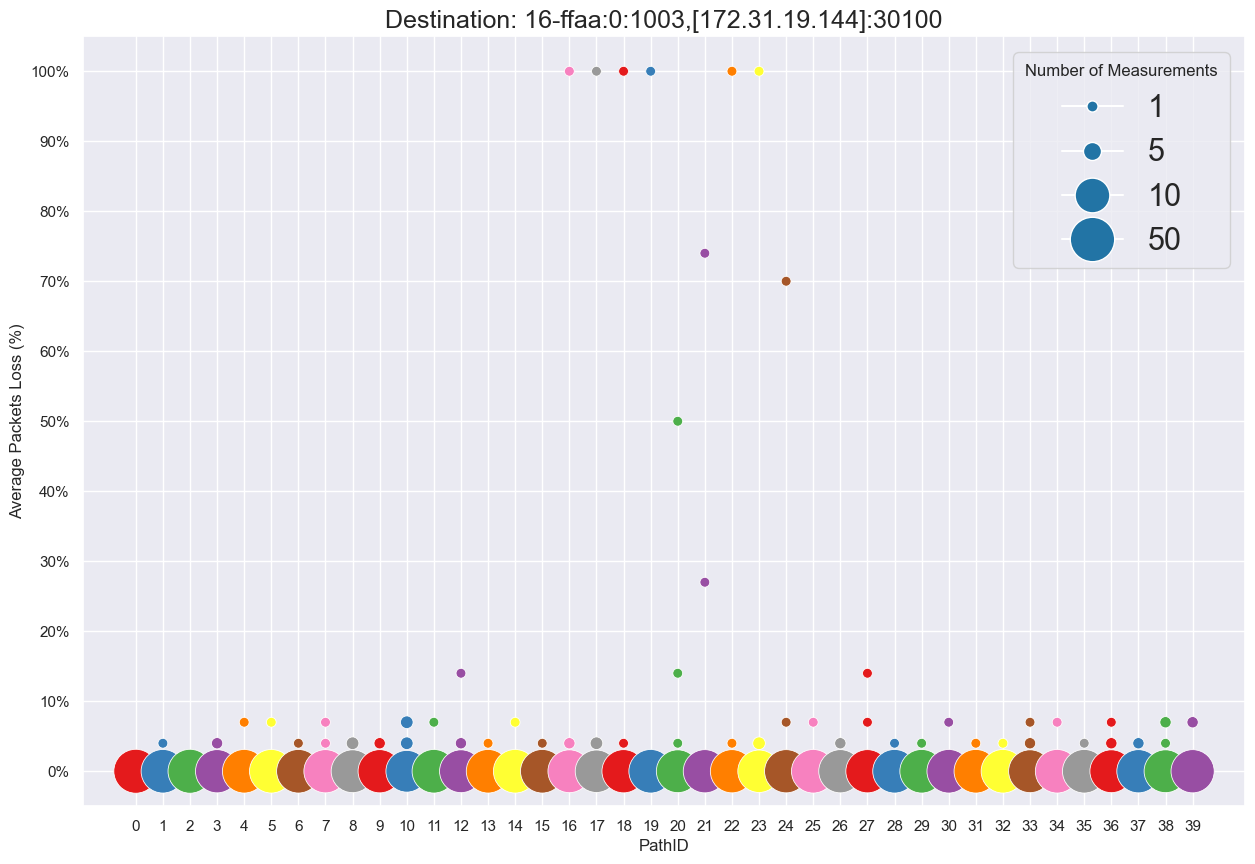

     _id  avg_loss  count
0    3_0         0     58
1    3_0         4      1
2    3_1         0     58
3    3_1         4      1
15   3_2         0     58
16   3_2         4      1
18   3_3         4      3
17   3_3         0     56
20   3_4        10      1
19   3_4         0     58
22   3_5         4      1
21   3_5         0     58
24   3_6         4      1
23   3_6         0     58
25   3_7         0     58
26   3_7         4      1
28   3_8         7      2
27   3_8         0     57
29   3_9         0     59
6   3_10         7      1
5   3_10         4      2
4   3_10         0     56
9   3_11         7      1
8   3_11         4      1
7   3_11         0     57
12  3_12        10      1
11  3_12         4      1
10  3_12         0     57
13  3_13         0     57
14  3_13         4      2


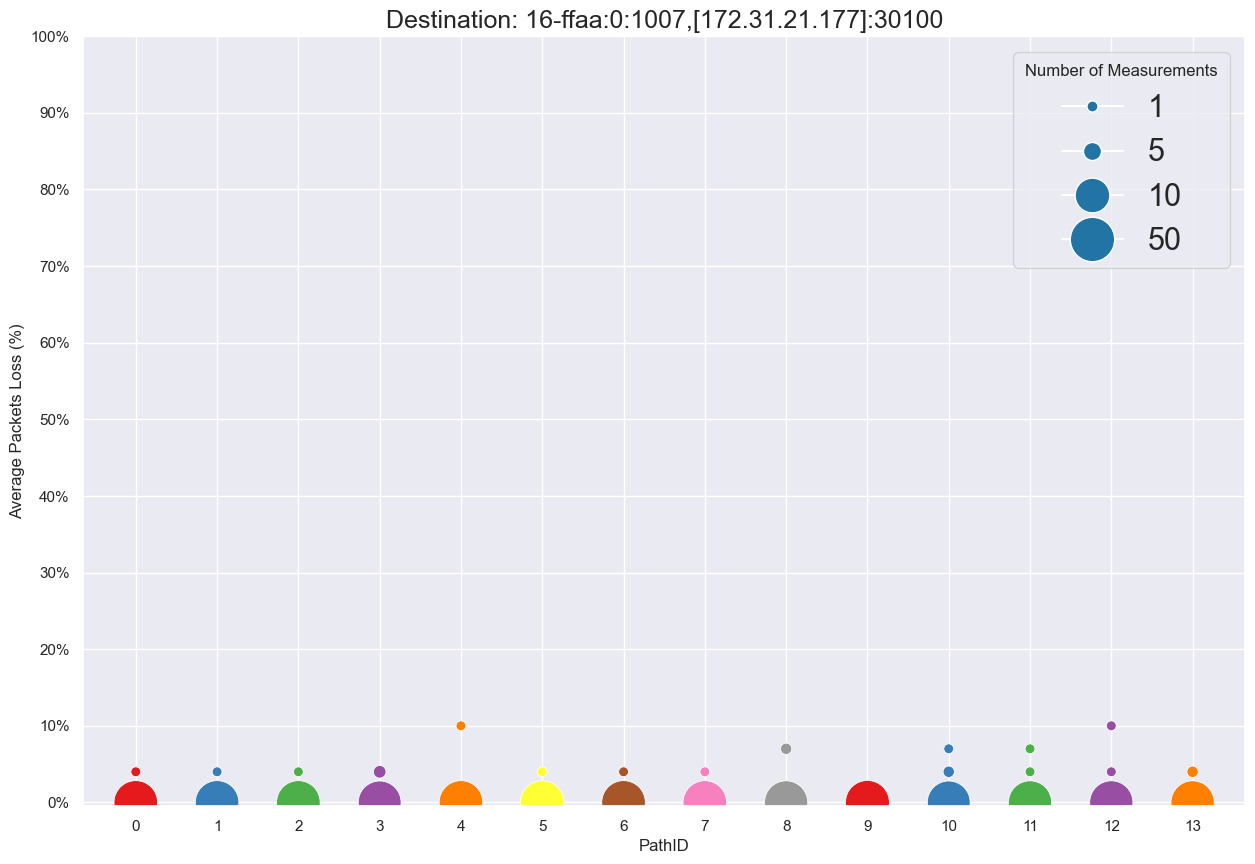

    _id  avg_loss  count
0   5_0         0     54
1   5_0         4      2
2   5_0         7      1
3   5_0        10      1
4   5_0        27      1
5   5_1         0     58
6   5_1         4      1
7   5_2         0     58
8   5_2         7      1
9   5_3         0     57
10  5_3         4      1
11  5_3         7      1
14  5_4         7      2
13  5_4         4      2
12  5_4         0     55
15  5_5         0     57
16  5_5         4      1
17  5_5         7      1
18  5_6         0     56
19  5_6         4      3
20  5_7         0     55
21  5_7         4      2
22  5_7         7      1
23  5_7        14      1
24  5_8         0     57
25  5_8         4      1
26  5_8        10      1
27  5_9         0     59


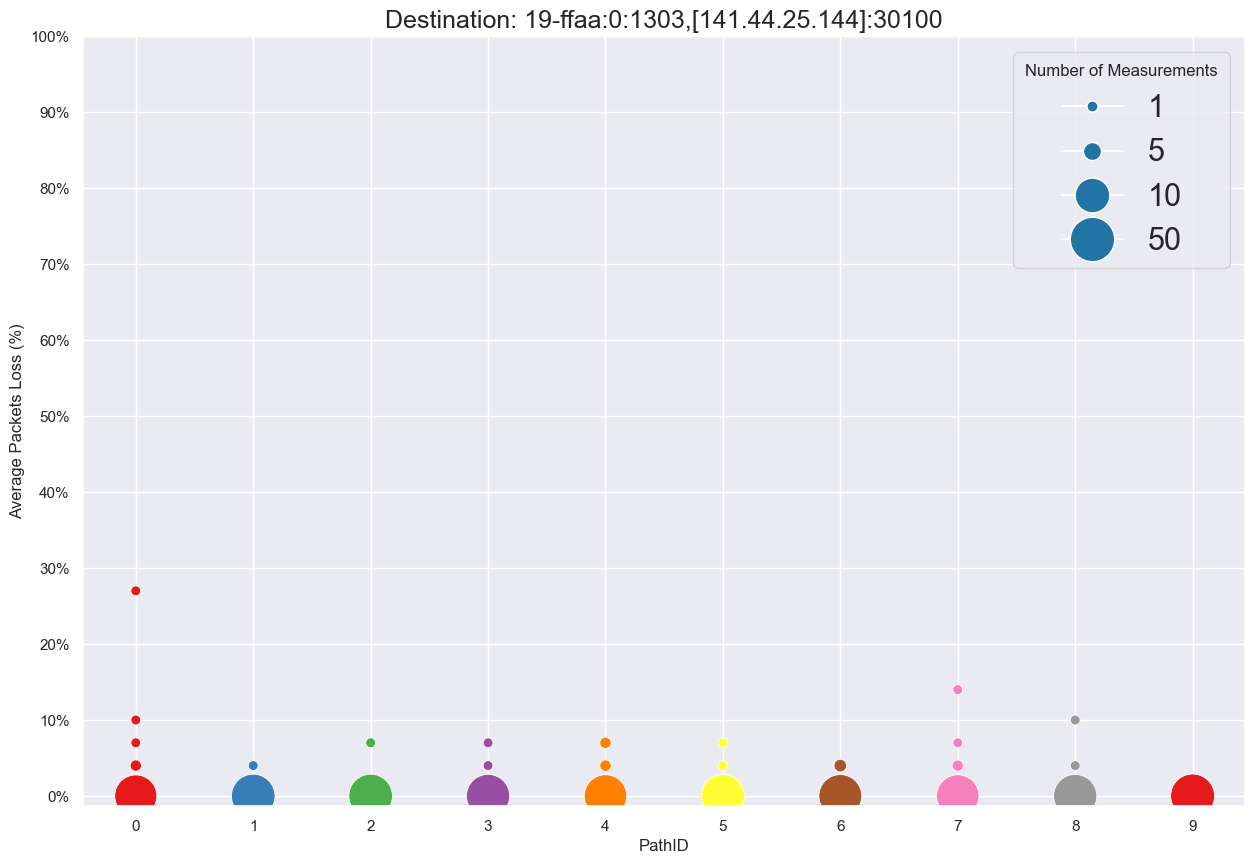

     _id  avg_loss  count
0    6_0         0     58
1    6_0         4      1
2    6_1         0     58
3    6_1         4      1
18   6_2         7      1
17   6_2         4      1
16   6_2         0     57
21   6_3        10      1
20   6_3         4      2
19   6_3         0     56
22   6_4         0     54
23   6_4         4      5
24   6_5         0     57
26   6_5        14      1
25   6_5         7      1
29   6_6         7      1
28   6_6         4      3
27   6_6         0     55
32   6_7        17      2
31   6_7         4      2
30   6_7         0     55
36   6_8        14      1
35   6_8         7      1
34   6_8         4      3
33   6_8         0     54
37   6_9         0     55
39   6_9        10      1
38   6_9         4      3
4   6_10         0     57
5   6_10         4      1
6   6_10        17      1
7   6_11         0     55
8   6_11         4      3
9   6_11        24      1
12  6_12         7      2
11  6_12         4      1
10  6_12         0     56
15  6_13    

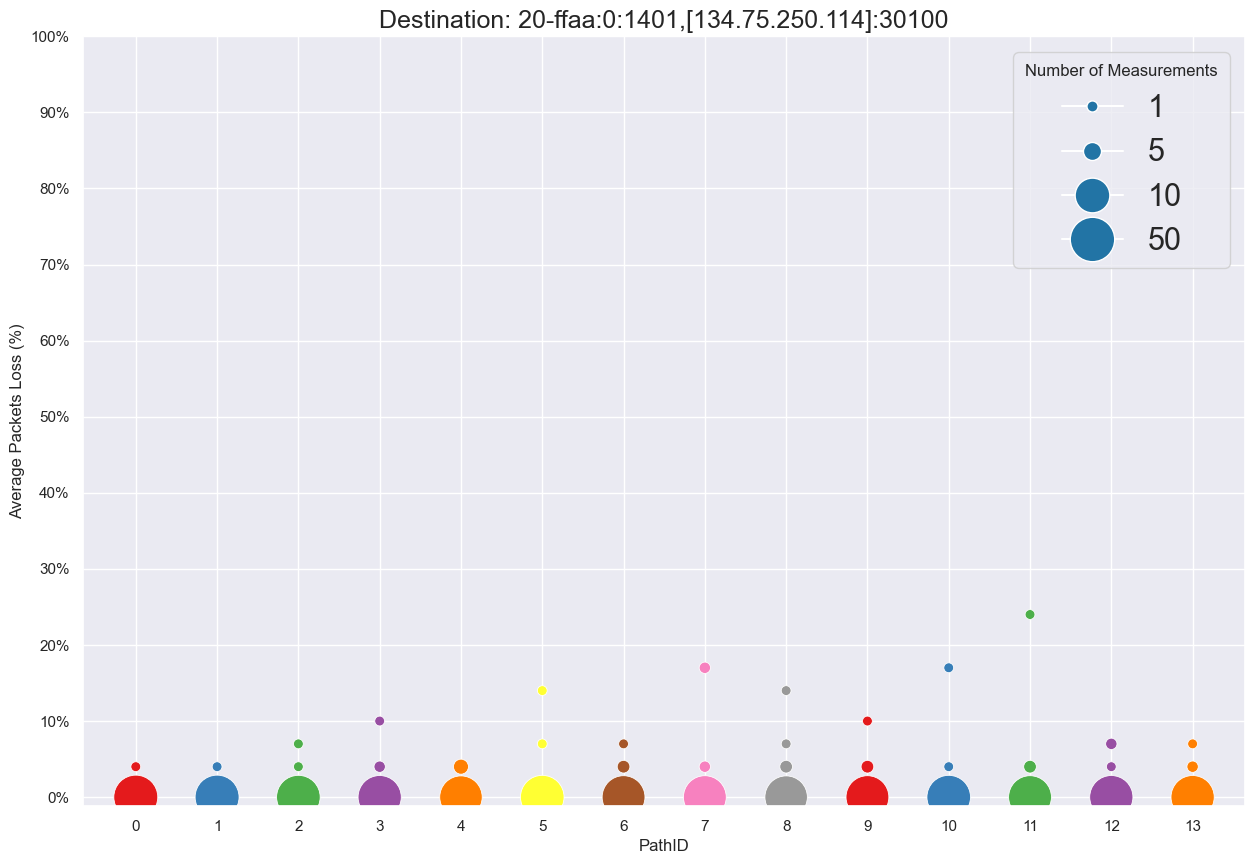

In [184]:
destinations = dflss['_id'].str.split('_', expand=True)[0].unique()

# Create custom color palette based on the number of unique paths
unique_paths = dflss['_id'].str.split('_', expand=True)[1].unique()
palette = sns.color_palette("Set1", n_colors=40)

# Create custom ticks for y-axis
custom_ticks = [10 * i for i in range(11)]

# Define a custom sorting function based on ID parts
def custom_sort_key(id_str):
    parts = id_str.split('_')
    return int(parts[1])  # Only sort by the second part (numeric part)

# Iterate over destinations and create a graph for each
# Iterate over destinations and create a graph for each
for destination in destinations:
    data = dflss[dflss['_id'].str.startswith(destination)]
    
    server = servers_df[servers_df['_id'] == int(destination)]['source_address'].iloc[0]
    
    # Group data by '_id' and 'avg_loss', then count the number of occurrences
    grouped_data = data.groupby(['_id', 'avg_loss']).size().reset_index(name='count')
    
    # Sort the DataFrame based on custom sort key
    grouped_data['_id'] = grouped_data['_id'].apply(custom_sort_key)
    grouped_data = grouped_data.sort_values(by='_id')
    grouped_data['_id'] = grouped_data['_id'].apply(lambda x: f"{destination}_{x}")
    
    # Calculate the size of the dots based on the count
    dot_sizes = grouped_data['count'] * 10
    # print(grouped_data)
    fig, ax = plt.subplots(figsize=(15, 10))
    
    sns.scatterplot(data=grouped_data, x=grouped_data['_id'].str.split('_', expand=True)[1], y="avg_loss", hue="_id",
                    size=dot_sizes, sizes=(50, 1000), palette=palette, legend=False, ax=ax)
    
    ax.set_xlabel("PathID")
    ax.set_ylabel("Average Packets Loss (%)")
    ax.set_title(f"Destination: {server}", fontsize=18)
    ax.set_yticks(custom_ticks)
    
    # Reverse the y-axis labels and invert the y-axis
    ax.set_yticklabels([f"{tick}%" for tick in custom_ticks])

    # Create a custom legend indicating the size of dots
    sizes = [1, 5, 10, 50]
   
    # Calculate the scaling factor for the legend dots based on the plot size range
    legend_sizes = [8, 13, 25, 32]

    handles = [plt.Line2D([0], [0], marker='o', color='w', label=f"{size}", 
                        markersize=legend_size, markerfacecolor="#2274a5") for size, legend_size in zip(sizes, legend_sizes)]
    scatter_legend = ax.legend(handles=handles, title="Number of Measurements", loc="upper right",
                            bbox_to_anchor=(1, 1), prop={'size': 22})

    plt.savefig(f"../../graphs/Loss/loss_destination_{destination}.png")
    plt.show()